# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

import params
from densenet_efficient import DenseNetEfficient
from solver import train, test_epoch
from dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
mean = 0.5 #457.38
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
train_set = WCDataset(params, transform=train_transforms)
print("Number of Training/Validation Images: %i" % len(train_set))
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)

Number of Training/Validation Images: 6
<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [3]:
mean = 0.5 #457.38
stdv = 0.25
test_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
test_set = WCDataset(params, transform=test_transforms, train=False)
print("Number of Testing Images: %i" % len(test_set))
x,y = test_set[0]
print(type(x), x.shape, type(y), y.shape)

Number of Testing Images: 2148
<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

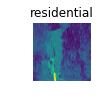

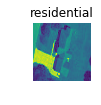

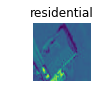

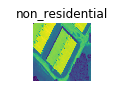

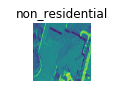

In [4]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(train_set), size, replace=False)

fig = plt.figure()

for i, idx in enumerate(indices):
    image, label = train_set[idx]
    plt.subplot(1, size, i + 1)
    plt.title(params['rbc_class_names'][label[0]])
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.show()

## Load Model
Load in DenseNet. Configure training parameters. 

In [5]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=20, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
# print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters: %i" % pytorch_total_params)

Total Parameters: 6968084


/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


In [7]:
# Load an existing model trained on 20 categories
model.load_state_dict(torch.load('/home/feng/ext2/feng/workspace/residential_building_challenge/output/cat_2_fmow_50000/model.dat'))

In [6]:
# Modify the model to predict 2 categories
# model.classifier = nn.Sequential(
#               nn.Linear(1024, 128),
#               nn.ReLU(),
#               nn.Linear(128, 2))

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [8]:
train(model, 
      train_set, 
      None, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/output/cat_2_fmow_50000_wake_5', 
      n_epochs=10, 
      valid_size=1,
      batch_size=50, 
      lr=0.01, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

Epoch: [1/10]	Iter: [1/1]	Time 0.619 (0.619)	Loss 2.9233 (2.9233)	Error 0.6000 (0.6000)
mean image:
364.9834899902344
Valid	Iter: [1/1]	Time 0.037 (0.037)	Loss 0.1782 (0.1782)	Error 0.0000 (0.0000)
[[1 0]
 [0 0]]
New best error: 0.0000
Epoch: [2/10]	Iter: [1/1]	Time 0.149 (0.149)	Loss 0.0025 (0.0025)	Error 0.0000 (0.0000)
mean image:
364.9834899902344
Valid	Iter: [1/1]	Time 0.040 (0.040)	Loss 1.1295 (1.1295)	Error 1.0000 (1.0000)
[[0 1]
 [0 0]]
Epoch: [3/10]	Iter: [1/1]	Time 0.149 (0.149)	Loss 0.0013 (0.0013)	Error 0.0000 (0.0000)
mean image:
364.98345947265625
Valid	Iter: [1/1]	Time 0.045 (0.045)	Loss 2.7618 (2.7618)	Error 1.0000 (1.0000)
[[0 1]
 [0 0]]
Epoch: [4/10]	Iter: [1/1]	Time 0.153 (0.153)	Loss 0.0009 (0.0009)	Error 0.0000 (0.0000)
mean image:
364.98345947265625
Valid	Iter: [1/1]	Time 0.043 (0.043)	Loss 4.0045 (4.0045)	Error 1.0000 (1.0000)
[[0 1]
 [0 0]]
Epoch: [5/10]	Iter: [1/1]	Time 0.152 (0.152)	Loss 0.0007 (0.0007)	Error 0.0000 (0.0000)
mean image:
364.9835205078125
Valid

TypeError: object of type 'NoneType' has no len()

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

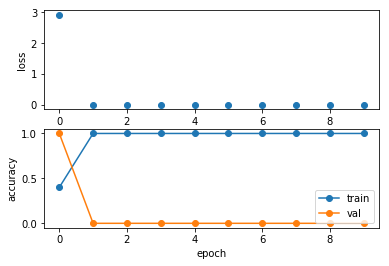

In [9]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/output/cat_2_fmow_50000_wake_5', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [10]:
# Check accuracy of model on Test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
test_epoch(model, test_loader)

Test	Iter: [1/135]	Time 0.168 (0.168)	Loss 1.9254 (1.9254)	Error 0.3750 (0.3750)
Test	Iter: [2/135]	Time 0.123 (0.146)	Loss 0.7730 (1.3492)	Error 0.2500 (0.3125)
Test	Iter: [3/135]	Time 0.102 (0.131)	Loss 0.6619 (1.1201)	Error 0.1250 (0.2500)
Test	Iter: [4/135]	Time 0.092 (0.121)	Loss 0.2039 (0.8911)	Error 0.1250 (0.2188)
Test	Iter: [5/135]	Time 0.090 (0.115)	Loss 0.3854 (0.7899)	Error 0.1250 (0.2000)
Test	Iter: [6/135]	Time 0.091 (0.111)	Loss 1.4253 (0.8958)	Error 0.5625 (0.2604)
Test	Iter: [7/135]	Time 0.091 (0.108)	Loss 1.3017 (0.9538)	Error 0.3750 (0.2768)
Test	Iter: [8/135]	Time 0.088 (0.106)	Loss 0.9979 (0.9593)	Error 0.4375 (0.2969)
Test	Iter: [9/135]	Time 0.089 (0.104)	Loss 1.4322 (1.0119)	Error 0.2500 (0.2917)
Test	Iter: [10/135]	Time 0.090 (0.102)	Loss 0.2495 (0.9356)	Error 0.1250 (0.2750)
Test	Iter: [11/135]	Time 0.089 (0.101)	Loss 0.6203 (0.9070)	Error 0.1875 (0.2670)
Test	Iter: [12/135]	Time 0.090 (0.100)	Loss 0.7570 (0.8945)	Error 0.2500 (0.2656)
Test	Iter: [13/135]	Time 

Test	Iter: [102/135]	Time 0.083 (0.085)	Loss 1.1048 (0.9566)	Error 0.3125 (0.2917)
Test	Iter: [103/135]	Time 0.083 (0.085)	Loss 0.8519 (0.9556)	Error 0.3125 (0.2919)
Test	Iter: [104/135]	Time 0.083 (0.085)	Loss 0.8771 (0.9549)	Error 0.3125 (0.2921)
Test	Iter: [105/135]	Time 0.082 (0.085)	Loss 1.1830 (0.9570)	Error 0.4375 (0.2935)
Test	Iter: [106/135]	Time 0.082 (0.085)	Loss 0.6835 (0.9544)	Error 0.3125 (0.2936)
Test	Iter: [107/135]	Time 0.082 (0.085)	Loss 0.7264 (0.9523)	Error 0.2500 (0.2932)
Test	Iter: [108/135]	Time 0.084 (0.085)	Loss 1.0379 (0.9531)	Error 0.1875 (0.2922)
Test	Iter: [109/135]	Time 0.083 (0.085)	Loss 1.3863 (0.9571)	Error 0.3125 (0.2924)
Test	Iter: [110/135]	Time 0.083 (0.085)	Loss 0.7197 (0.9549)	Error 0.3125 (0.2926)
Test	Iter: [111/135]	Time 0.082 (0.085)	Loss 0.3004 (0.9490)	Error 0.1250 (0.2911)
Test	Iter: [112/135]	Time 0.085 (0.085)	Loss 1.2987 (0.9521)	Error 0.3125 (0.2913)
Test	Iter: [113/135]	Time 0.084 (0.085)	Loss 1.4479 (0.9565)	Error 0.3750 (0.2920)
Test

(0.08392010618139197, 0.9483628641238204, 0.28677839851024206)

### Visualize Successful and Failed Examples

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()